## Анализ пользовательского поведения в мобильном приложении

***Описание проекта***

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работаем с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

***Описание данных***

Каждая запись в логе — это действие пользователя, или событие. 

- `EventName` — название события;

- `DeviceIDHash` — уникальный идентификатор пользователя;

- `EventTimestamp` — время события;

- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Откроем файл с данными и изучим общую информацию

Импортируем необходимые библиотеки и загрузим датасет

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth
colors =["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Мы видим логи событий приложения с указанием названия события, ID пользователя, времени события и номера эксперимента

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Типы некоторых столбцов некорректны для проведения анализа. Подготовим данные.

## Подготовка данных

Заменим названия столбцов на удобные

In [4]:
df.columns = ['event_name', 'user_id', 'datetime', 'group']
df.head()

,event_name,user_id,datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Отлично! 

Преобразуем столбец datetime в привычный формат.

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   datetime    244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Тип данных даты изменили, с остальными столбцами всё в порядке. Также мы видим, что в каждом столбце одинаковое количество записей, следовательно пропуски отсутствуют. Проверим:

In [6]:
df.isnull().sum().to_frame()

,0
event_name,0
user_id,0
datetime,0
group,0


Всё верно, пропущенных значений нет. Проверим дубликаты:

In [7]:
df.duplicated().sum()

413

Имеем 413 дубликатов, что составляет менее 0,2% от общего количества записей в датафрейме (244126). Следовательно, дубликаты можно смело удалить, это не окажет влияния на общие результаты.

In [8]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Дубликатов больше нет.

Добавим в датафрейм столбец с датой (без времени)

In [9]:
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'])

In [10]:
df.head()

,event_name,user_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   datetime    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [12]:
df['group'].value_counts()

248    85582
246    80181
247    77950
Name: group, dtype: int64

In [13]:
group_246 = df[df['group'] == '246']['user_id']
group_247 = df[df['group'] == '247']['user_id']
group_248 = df[df['group'] == '248']['user_id']
df_246_247_248 = df.query('user_id in @group_246 and user_id in @group_247 and user_id in @group_248')
display(df_246_247_248['user_id'].unique())
print('Количество пересекающихся пользователей в трех группах:', df_246_247_248['user_id'].nunique())
print('Всего пользователей в тесте:', df['user_id'].nunique())

array([], dtype=int64)

Количество пересекающихся пользователей в трех группах: 0
Всего пользователей в тесте: 7551


В датафрейме нет пользователей, попавшие в разные группы одновременно.

***Вывод:***
Мы заменили наименования столбцов на удобные, поменяли тип данных с информацией о дате и времени, удалили дубликаты, и добавили столбец с датой (без времени). Предобработка завершена!

## Изучим и проверим данные

### Сколько всего событий в логе?

In [14]:
print(f'Событий в логе - {len(df)}')

Событий в логе - 243713


### Сколько всего пользователей в логе?

In [15]:
print(f'Уникальных пользователей в логе - {df["user_id"].nunique()}')

Уникальных пользователей в логе - 7551


### Сколько в среднем событий приходится на пользователя?

In [16]:
print('В среднем событий приходится на пользователя - {}'.format(int(df.groupby('user_id')['event_name'].agg('count').median())))

В среднем событий приходится на пользователя - 20


### Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?

In [17]:
print('Перед нами логи за период с {} по {}.'.format(df['datetime'].min(), df['datetime'].max()))

Перед нами логи за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17.


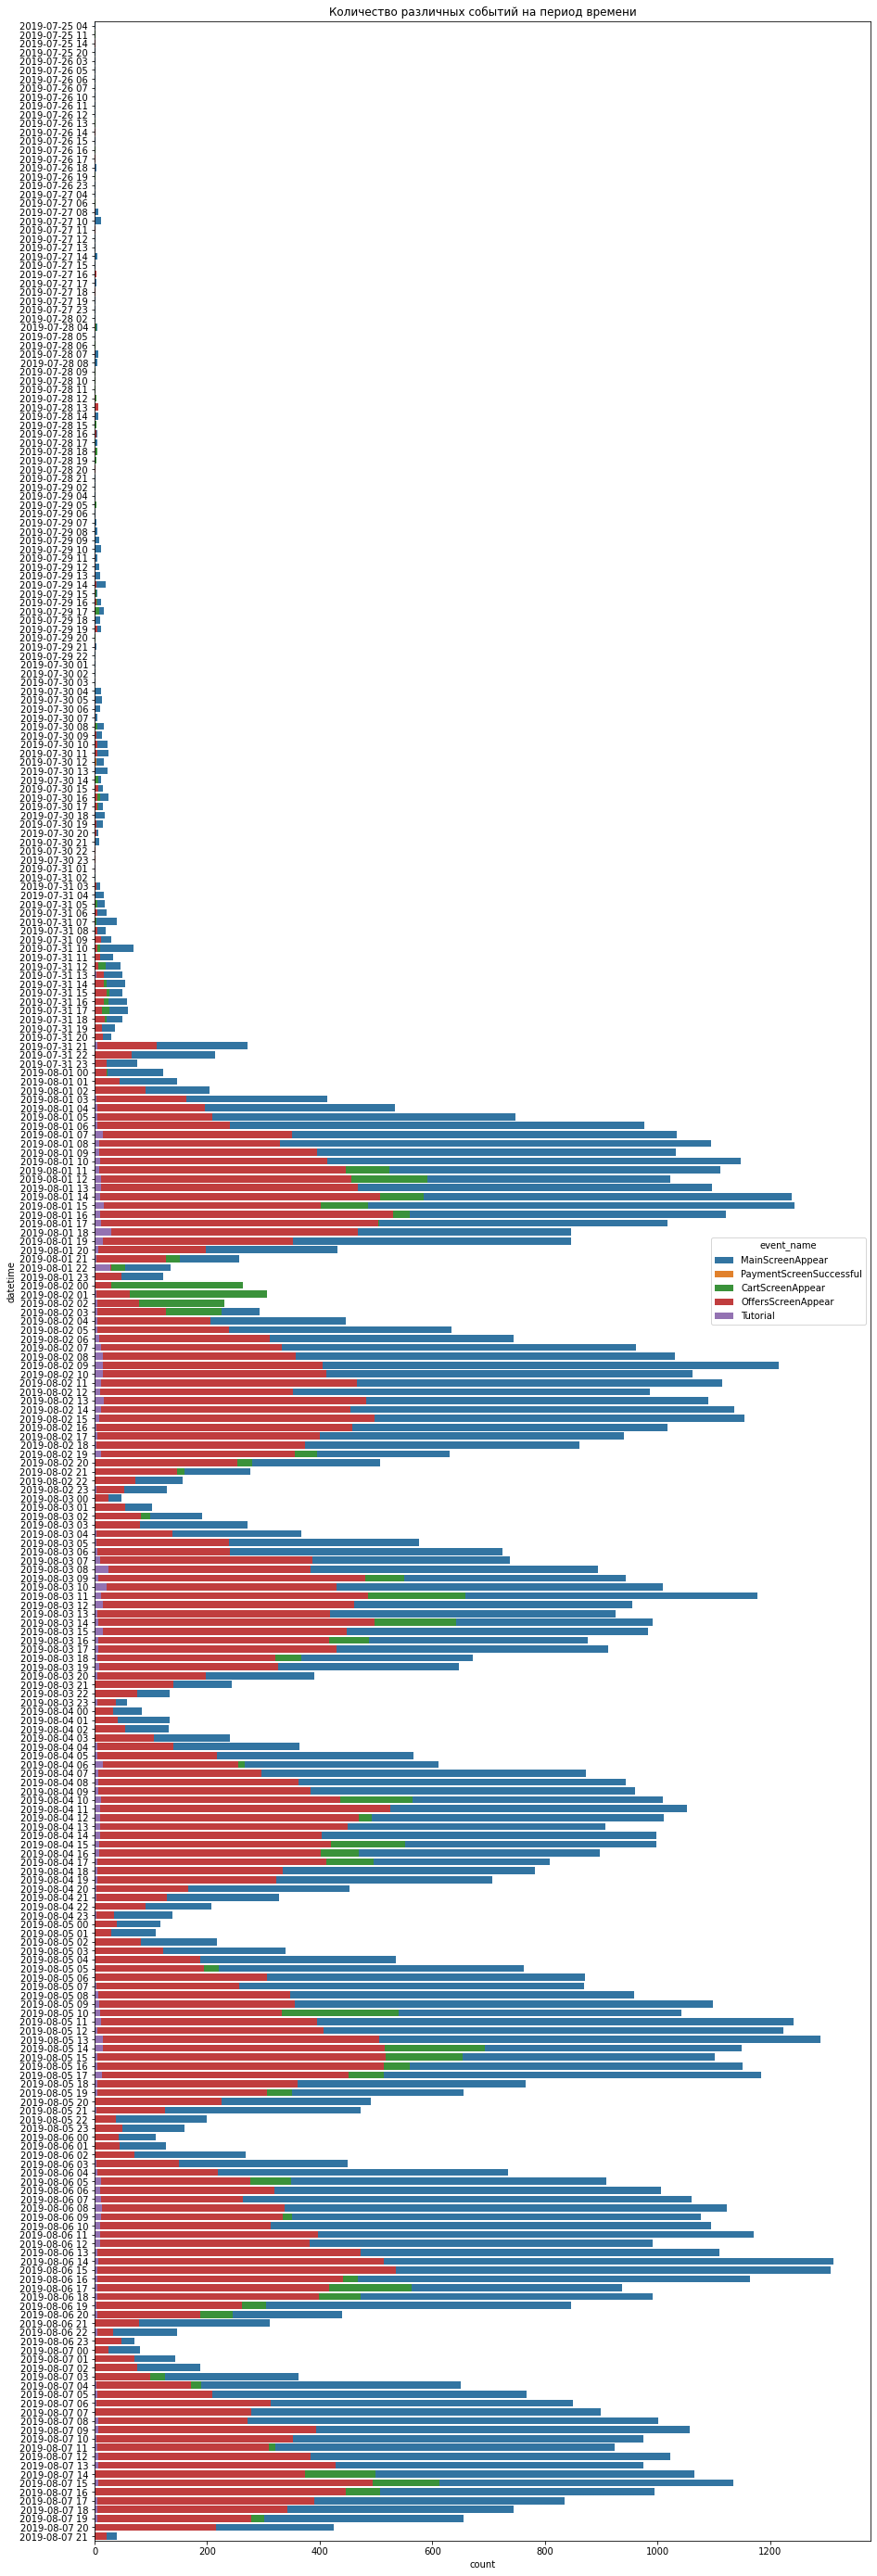

In [18]:
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=df['datetime'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=df, dodge=False)
ax.set_title('Количество различных событий на период времени')
plt.show()

Из гистограммы видно, что у нас одинаково полные данные имеются только за период с 2019-07-31 21:00 по 2019-08-07 21:00.

Отбросим неполные данные и оставим только вышеуказанный период. Перезапишем датафрейм с новым периодом и снова посмотрим на события и уникальных пользователей в логе и сколько в среднем событий приходится на пользователя.

In [19]:
logs = df['2019-07-31 21:00' <= df['datetime']]
print(f'Событий в логе - {len(logs)}')
print(f'Уникальных пользователей в логе - {logs["user_id"].nunique()}')
print('В среднем событий приходится на пользователя - {}'.format(int(logs.groupby('user_id')['event_name'].agg('count').median())))
print('Перед нами логи за период с {} по {}.'.format(logs['datetime'].min(), logs['datetime'].max()))


Событий в логе - 241724
Уникальных пользователей в логе - 7538
В среднем событий приходится на пользователя - 19
Перед нами логи за период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17.


Построим гистограмму с новым периодом с 2019-07-31 21:00:57 по 2019-08-07 21:15:17.

In [ ]:
plt.figure(figsize=(15, 35))
ax = sns.countplot(y=logs['datetime'].dt.strftime('%Y-%m-%d %H'),  data=logs, hue='group')
ax.set_title('Количество событий для каждой из групп')
plt.show()

### Посмотрим, сколько пользователей и событий мы потеряли при удалении части периода

In [ ]:
all_users = df['user_id'].nunique()
new_users = logs['user_id'].nunique()
print(f'Было пользователей = {all_users} / Стало = {new_users} / На сколько уменьшилось = {all_users-new_users} / Потеря = {round((all_users-new_users)/all_users*100,2)}%')

all_events = df['event_name'].count()
new_events = logs['event_name'].count()
print(f'Было событий = {all_events} / Стало = {new_events} / На сколько уменьшилось = {all_events-new_events} / Потеря = {round((all_events-new_events)/all_events*100,2)}%')

***Вывод:***

 Дальнейший анализ будем проводить с актуальными данными за период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17.
 
- Событий в логе - 241724 (отличие от неочищенных данных (243713) менее 1%)

- Уникальных пользователей в логе - 7538 (отличие от неочищенных данных (7551) менее 1%)

- В среднем событий приходится на пользователя - 19 (отличие от неочищенных данных (20) менее 1%)

***Отбросив неполные данные мы практически ничего не потеряли (менее 1% событий и пользователей) и можем спокойно продолжать анализ, основываясь на актуальном периоде.***

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [ ]:
logs.groupby('group')['user_id'].nunique()

Из анализа видно, что у нас имееются пользователи из всех трёхэкспериментальных данных и относительно в равных количествах (в районе 2,5 тыс).

***Вывод:***

В ходе изучения и проверки данных определили актуальный период, с которым в дальнейшем и будем работать (с 2019-07-31 21:00:57 по 2019-08-07 21:15:17). После актуализации периода обнаружили, что потери в количестве пользователей и событий составили менее 1%. Это очень мало, поэтому можем смело отбросить старые данные и продолжить проверку.

## Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [ ]:
events_count = logs['event_name'].value_counts().to_frame()
events_count

In [ ]:
fig = go.Figure(data=[go.Pie(labels=logs['event_name'].value_counts().index, values=logs['event_name'].value_counts(), \
                             title='Доли событий')])
fig.show()

- Самое частое событие - это появление основного экрана(MainScreenAppear) случалось 117889 раз (48,8%)

- Второе по популярности событие - появление экрана с каталогом продуктов(OffersScreenAppear) случалось 46531 раз (19,2%)

- Третье - появление экрана с корзиной(CartScreenAppear) случалось 42343 раза (17,5%)

- Четвёртое - появление экрана с успешной оплатой(PaymentScreenSuccessful) случалось 33951 раз (14%)

- Пятое - открытие руководства пользователя(Tutorial) случалось 1010 раз (0,42%)

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [ ]:
events_users = logs.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_users.columns = ['n_events', 'users']
events_users = events_users.reset_index()
events_users['users_part_1event'] = (events_users['users'] / logs['user_id'].nunique() * 100).round(1) # доля хотя бы раз совершивших событие
events_users

`n_events` - количество событий

`users` - количество пользователей

`users_part_1event` - доля пользователей, совершивших хотя бы одно событие

***Вывод:***
    
MainScreenAppear - название события, где самое большое число событий, пользователей и доля пользователей, совершивших хотя бы одно событие. В целом, воронка выглядит так:

- MainScreenAppear - зашли на сайт

- OffersScreenAppear - искали товар по каталогу

- CartScreenAppear - добавили в корзину

- PaymentScreenSuccessful - оплатили

- Tutorial - изучали инструкцию

### Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки

В предыдущем пункте мы уже выяснили, в каком порядке происходят события. Посмотрим на графиках

Построим график Cобытии по числу пользователей

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(y='users', x='event_name', data=events_users);
plt.xlabel('СОБЫТИЕ')
plt.ylabel('Количество пользователей')
plt.title('События по числу пользователей')
plt.show();

Построим график по долям пользователей

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(y=('users_part_1event'), x='event_name', data=events_users);
plt.xlabel('СОБЫТИЕ')
plt.ylabel('ДОЛЯ, %')
plt.title('Доли пользователей совершивших хоть одно событие от всех пользователей')
plt.show();

Предположим, что пользователь

- сначала открывает главную страницу приложения(MainScreenAppear) 

- потом в каталоге выбирает товары(OffersScreenAppear)

- кладёт их в корзину(CartScreenAppear) 

- и оплачивает(PaymentScreenSuccessful)

Читает инструкцию (Tutorial) - единицы пользователей.

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B

***Поскольку событие Tutorial по всей видимости не оказывает влияние на практические результаты и непонятно, какая от него польза, и на какое участие он принимает в последовательности. Уберем его из таблицы. Для дальнейшего расчета перезапишем logs и снова events_users без Tutorial***

In [ ]:
logs = logs.query('event_name != "Tutorial"')
events_users = logs.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_users.columns = ['n_events', 'users']
events_users = events_users.reset_index()
events_users['users_part_1event'] = (events_users['users'] / logs['user_id'].nunique() * 100).round(1) # доля хотя бы раз совершивших событие
events_users

In [ ]:
logs1 = logs.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_list()
logs1

In [ ]:
print(f'С главного экрана в каталог товаров перешло - {round(logs1[1]/logs1[0] *100, 2)} % пользователей')
print(f'С каталога товаров в корзину перешло - {round(logs1[2]/logs1[1] *100, 2)} % пользователей')
print(f'С корзины до экрана успешной оплаты перешло - {round(logs1[3]/logs1[2] *100, 2)} % пользователей')

Напишем функцию для того, чтобы посмотреть по воронке, какая доля пользователей переходит на следующий шаг воронки в разрезе групп.

In [ ]:
prev_users = events_users.loc[0,'users']
start_users = prev_users

for i in events_users.index:
    events_users.loc[i,'from_last'] = (events_users.loc[i,'users'] / prev_users * 100).round(2)
    events_users.loc[i,'from_start'] = (events_users.loc[i,'users'] / start_users * 100).round(2)
    prev_users = events_users.loc[i,'users']
events_users 

- `from_last` - доля пользователей перешедших с предыдущего этапа

- `welcome_from_start` - доля пользователей с первоначального этапа

Посмотрим как это выглядит на воронке

In [ ]:
fig = go.Figure(go.Funnel(x = events_users['from_last'], y = events_users['event_name']))
fig.show()


- С главного экрана в каталог товаров перешло - 61.93 % пользователей

- С каталога товаров в корзину перешло - 81.27 % пользователей

- С корзины до экрана успешной оплаты перешло - 94.75 % пользователей

### На каком шаге теряем больше всего пользователей?

In [ ]:
print(f'При переходе с главного экрана в каталог товаров теряется  - {100 - round(logs1[1]/logs1[0] *100, 2)} % пользователей')
print(f'При переходе из каталога товаров в корзину  - {100 - round(logs1[2]/logs1[1] *100, 2)} % пользователей')
print(f'При переходе из корзины до экрана успешной оплаты  - {100 - round(logs1[3]/logs1[2] *100, 2)} % пользователей')

***Больше всего пользователей теряется при переходе с главного экрана в каталог товаров.***

### Какая доля пользователей доходит от первого события до оплаты?

In [ ]:
print(f'Доля пользователей доходит от первого события до оплаты  - {round(logs1[3]/logs1[0] *100, 2)} % пользователей')

## Изучим результаты эксперимента

***Поскольку событие "Tutorial" по всей видимости не оказывает влияние на практические результаты и непонятно, какая от него польза, уберем его из таблицы***

In [ ]:
logs = logs.query('event_name != "Tutorial"')

### Сколько пользователей в каждой экспериментальной группе?

In [ ]:
logs.groupby('group')['user_id'].nunique()

В двух контрольных группах 246 и 247 - 2483 и 2516 пользователей соответственно, в экспереминтальной 248 - 2535 пользователя.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Выделим группы 

In [ ]:
logs_246 = logs.query('group == 246')
logs_247 = logs.query('group == 247')
logs_248 = logs.query('group == 248')

In [ ]:
count_user246 = logs_246['user_id'].nunique()
count_user246

In [ ]:
count_user247 = logs_247['user_id'].nunique()
count_user247

In [ ]:
count_user248 = logs_248['user_id'].nunique()
count_user248

Сгруппиируем данные по группам

In [ ]:
logs_group246 = logs_246.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_list()
logs_group246

In [ ]:
logs_group247 = logs_247.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_list()
logs_group247

In [ ]:
logs_group248 = logs_248.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_list()
logs_group248

In [ ]:
purchases = logs_group246[1], logs_group247[1]
purchases[0]

In [ ]:
logs_group = logs.pivot_table(index='event_name', values='user_id', columns='group',aggfunc=lambda x: len(x.unique()))
logs_group = logs_group.reset_index().sort_values(by=246, ascending=False).reset_index(drop=True)
logs_group

Запишем функцию и применим поправку Бонферрони

In [ ]:
def hypothesis_testing(purchasesA,purchasesB,leadsA,leadsB, event_name, alpha = 0.05/4):
    
    p1 = purchasesA/leadsA
    p2 = purchasesB/leadsB

    p_combined = (purchasesA + purchasesB) / (leadsA + leadsB)
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leadsA + 1/leadsB))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value =(1 - distr.cdf(abs(z_value))) * 2
    print(f'Расчет теста для действия пользователей {event_name}')
    print('p-значение: ', p_value)

    if p_value < alpha:

        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('---------------------------------------------------------------------------')

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Посмотрим на число пользователей, совершивших самое популярное событие в каждой группе, и на долю пользователей, совершивших это событие

In [ ]:
logs_group = logs.pivot_table(index='event_name', values='user_id', columns='group',aggfunc=lambda x: len(x.unique()))
logs_group = logs_group.sort_values(by=246, ascending=False)
logs_group['246/247'] = 1 - (logs_group[246]/ logs_group[247]) * 100
logs_group = logs_group.reset_index()
logs_group.style.highlight_max()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = '246 группа',
    y = logs_group["event_name"],
    x = logs_group[246],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#39A388"}))

fig.add_trace(go.Funnel(name = '247 группа',
    y = logs_group["event_name"],
    x = logs_group[247],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#2C2891"}))
fig.update_layout(title='Распределение количества пользователей по их действиям в группах 246 и 247',height=600, width=1000)
fig.show()

MainScreenAppear самое популярное событие

Сформулируем гипотезы 

Н0 - В значениях групп 246 и 247 нет существенной разницы 

Н1 - В значениях групп 246 и 247 есть существенная разница

Проведем тест

In [ ]:
t = [hypothesis_testing(logs_group[246][i],logs_group[247][i], count_user246,
                    count_user247,logs_group['event_name'][i], alpha = 0.05/len(logs_group[246])) for i in range(len(logs_group[246]))]

***Не получилось отвергнуть нулевую гипотезу, в значениях групп 246 и 247 нет существенной разницы, контрольные группы сформированны правильно.***

### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = '246 группа',
    y = logs_group["event_name"],
    x = logs_group[246],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#39A388"}))

fig.add_trace(go.Funnel(name = '248 группа',
    y = logs_group["event_name"],
    x = logs_group[248],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#FFFD95"}))

fig.add_trace(go.Funnel(name = '247 группа',
    y = logs_group["event_name"],
    x = logs_group[247],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#2C2891"}))
fig.update_layout(title='Распределение количества пользователей по их действиям в группах 246,247,248',height=600, width=1000)
fig.show()

Сформулируем гипотезы. 

Н0 - В значениях групп 248 и 247 нет существенной разницы

Н1 - В значениях групп 248 и 247 есть существенная разница

Проведем тест

In [ ]:
t1 = [hypothesis_testing(logs_group[248][i],logs_group[247][i],count_user248,
                    count_user247,logs_group['event_name'][i], alpha =  0.05/len(logs_group[248])) for i in range(len(logs_group[248]))]

***Не получилось отвергнуть нулевую гипотезу, в значениях групп 247 и 248 нет существенной разницы***

Сформулируем гипотезы 

Н0 - В значениях групп 248 и 246 нет существенной разницы

Н1 - В значениях групп 248 и 246 есть существенная разница 

Проведем тест

In [ ]:
t2 = [hypothesis_testing(logs_group[248][i],logs_group[246][i],count_user248,
                    count_user246,logs_group['event_name'][i], alpha =  0.05/len(logs_group[248])) for i in range(len(logs_group[248]))]

***Не получилось отвергнуть нулевую гипотезу, в значениях групп 246 и 248 нет существенной разницы***

In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = '248 группа',
    y = logs_group["event_name"],
    x = logs_group[248],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#8CA1A5"}))

fig.add_trace(go.Funnel(name = '247 и 246 группы',
    y = logs_group["event_name"],
    x = logs_group[247]+logs_group[246],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#316B83"}))
fig.update_layout(title='Распределение количества пользователей по их действиям в группах 248 и объединённой контрольной группой ',height=500, width=900)
fig.show()

Сформулируем гипотезы 

Н0 - В значениях групп 248 и объединенной группы нет существенной разницы 

Н1 - В значениях групп 248 и объединенной группы есть существенная разница 

Проведем тест.

In [ ]:
logs_group

In [ ]:
t3 = [hypothesis_testing(logs_group[248][i],logs_group[246][i]+logs_group[247][i],count_user248,
                    (count_user246+count_user247),logs_group['event_name'][i], alpha =  0.05/len(logs_group[248])) for i in range(len(logs_group[248]))]

***Не получилось отвергнуть нулевую гипотезу, тест не зафиксировал существенной разницы между группой 248 и объединенной группой***

### Какой уровень значимости мы выбрали при проверке статистических гипотез выше? Посчитаем, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если мы хотите изменить его, проделаем предыдущие пункты и проверим свои выводы.

Я выбрала уровень значимости 0,05 и провела 16 проверок статистических гипотез. .

Считаю, что в данном случае самый оптимальный уровень значимости - 0.05, так как выборки примерно равны между собой и, следовательно, достаточно чувствительны. При выборе уровня значимости в 0.1 увеличиваются шансы получить ложноположительные результаты и найти различия там, где их нет.

## Вывод

Анализируя гистограмму по дате и времени, мы приняли решение отбросить неполные данные и оставить только период с 2019-07-31 21:00.

При исследовании воронки событий мы выяснили

- от первого события до оплаты доходит меньше половины пользователей - 47,69%

- 7423 пользователей (98,5%) хотя бы раз открывали главную страницу приложения (1,5% не смогли войти на главную страницу, видимо имеются какие-то технические неполадки)

- 4597 пользователей (61%) хотя бы раз открывали страницу с каталогом товаров (39% пользователей не увидели даже каталог товаров необходимо выяснить причину, возможно приложение не на всех устройствах работает корректно)

- 3736 пользователей (49,6%) положили товар в корзину

- и только 3540 пользователя (47%) оплатили товар.

Мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.
При уровне значимости 0,1 результаты практически не меняются, но при этом каждый десятый раз можно получать ложноположительный результат.

В результате всех и каждого A/A/B эксперемента значимой разницы между группами не выявлено. Поэтому можно утверждать, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Тестирование можно назвать успешным.